In [ ]:
# 原始字段字符串
fields_str = '"fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"'

# 解析字段
fields = [f.strip('"') for f in fields_str.split(';')]

# 构造字典
result = {
    tuple(fields[i:i+2]): fields[i+2]
    for i in range(0, len(fields) - 2, 3)
}

In [ ]:
import numpy as np
import string
from watermarking_schemes.B2Mark import B2MarkWatermarkEmbedding

# watermark multi colomns
def generate_secret_keys(n, length=6):
    np.random.seed(99)  # 设置随机种子
    charset = list(string.ascii_letters + string.digits)  # 转换成字符列表
    secret_key_1s = [''.join(np.random.choice(charset, size=length)) for _ in range(n)]
    return secret_key_1s

g = 10
secret_key_s = generate_secret_keys(100)
dataset = "wine"

for idx, seed in enumerate(range(10000,10100)):
    for dict_idx in range(2,5):
        sliced_data = dict(list(result.items())[:dict_idx])
        for key, value in sliced_data.items():
            b2mark_watermark_embedding = B2MarkWatermarkEmbedding(
                dataset=dataset,
                seed=seed,
                g=g,
                secret_key=secret_key_s[idx],
                columns_of_interest=list(key),
                watermarked_colomn=value
            )
            if value == 'citric acid':
                b2mark_watermark_embedding.load_data(f'dataset/{dataset}-{seed}-{dict_idx-1}.npy')
            else:
                b2mark_watermark_embedding.load_data(f'dataset/{dataset}-{seed}-{dict_idx}.npy')
            b2mark_watermark_embedding.generate_segments()
            b2mark_watermark_embedding.process_data()
            b2mark_watermark_embedding.save_results(f'dataset/{dataset}-{seed}-{dict_idx}.npy')
        
        

In [ ]:
import numpy as np
import pandas as pd

def drop_colomns(num, file):

    loaded_results = np.load(file, allow_pickle=True).item()
    watermarked_file = loaded_results['watermarked_data']
        
    available_cols = [col for col in watermarked_file.columns if col != 'quality']
    
    if num > len(available_cols):
        raise ValueError(f"num={num} 超过了可删除列的数量 {len(available_cols)}")
    
    drop_cols = np.random.choice(available_cols, size=num, replace=False)
    
    df_dropped = watermarked_file.drop(columns=drop_cols)
    
    return df_dropped


def can_be_detected(file, result):
    df = file
    cols_in_file = set(df.columns)

    
    for key, value in result.items():
        key_set = set(key)
        if key_set.issubset(cols_in_file) and value in cols_in_file:
            return True  
    return False  

In [16]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.impute import SimpleImputer

class MLUtilityLinearRegression:
    def __init__(self, dataset_path, watermarked_data_path=None, test_size=0.3, random_state=45):
        self.dataset_path = dataset_path
        self.watermarked_data_path = watermarked_data_path
        self.test_size = test_size
        self.random_state = random_state
        self.model = LinearRegression()

    def load_data(self, file_path):
        _, file_extension = os.path.splitext(file_path)
        if(file_extension == '.csv'):
            data = pd.read_csv(file_path, sep=';', quotechar='"')
        elif(file_extension == '.npy'):
            loaded_results = np.load(file_path, allow_pickle=True).item()
            data = loaded_results['watermarked_data']
        return data

    def preprocess_data(self, data):
        X = data.drop(columns=['quality'])
        y = data['quality']
        X = X.dropna()
        y = y[X.index]
        return X, y

    def split_data(self, X, y):
        return train_test_split(X, y, test_size=self.test_size, random_state=self.random_state)

    def train_model(self, X_train, y_train):
        self.model.fit(X_train, y_train)

    def predict_and_evaluate(self, X_test, y_test):
        y_pred = self.model.predict(X_test)
        return mean_squared_error(y_test, y_pred)

    def compute_mse(self):        
        watermarked_data = self.watermarked_data_path
        X_watermarked, y_watermarked = self.preprocess_data(watermarked_data)
        X_train, _, y_train, _ = self.split_data(X_watermarked, y_watermarked)
        
        origin_data = self.load_data(self.dataset_path)
        origin_data = origin_data[watermarked_data.columns]
        X_origin, y_origin = self.preprocess_data(origin_data)
        _, X_test, _, y_test = self.split_data(X_origin, y_origin)

        self.train_model(X_train, y_train)
        mse_watermarked = self.predict_and_evaluate(X_test, y_test)
                
        return mse_watermarked

In [ ]:
fields_str = '"fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"'
fields = [f.strip('"') for f in fields_str.split(';')]
result = {
    tuple(fields[i:i+2]): fields[i+2]
    for i in range(0, len(fields) - 2, 3)
}

# drop columns
dataset = "wine"
origin = 'dataset/winequality-white.csv'
for idx in range(1,5):
    print(f"**************idx: {idx}****************")
    sliced_data = dict(list(result.items())[:idx])
    for drop_num in range(1, 11):
        print(f"**************drop_num: {drop_num}****************")
        canbedetected = 0
        mses =[]
        for seed in range(10000,10100):
            watermarked_data = f'dataset/{dataset}-{seed}-{idx}.npy'
            watermarked_data_dropped  = drop_colomns(drop_num, watermarked_data)
            if can_be_detected(watermarked_data_dropped, sliced_data):
                canbedetected += 1
            mlu = MLUtilityLinearRegression(dataset_path=origin, watermarked_data_path=watermarked_data_dropped)
            mse = mlu.compute_mse()
            mses.append(mse)
        
        print(f"can be detected: {canbedetected}")
        print(f"mean mse: {np.mean(mses)}")
            
        

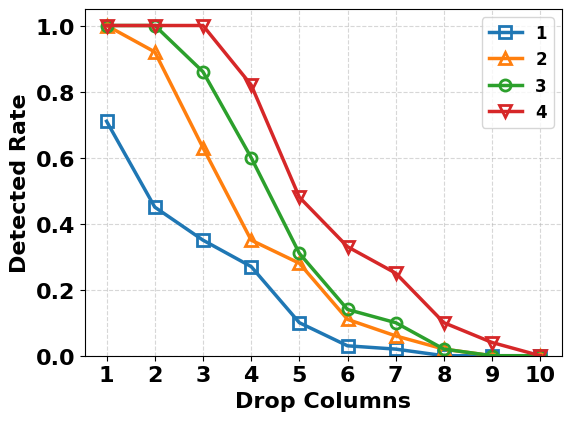

In [2]:
import json
import matplotlib.pyplot as plt

# 公共配置
plt.rcParams['font.size'] = 16
plt.rcParams['font.weight'] = 'bold'

# 读取 JSON 数据
with open("result.json", "r") as f:
    data = json.load(f)

drop_nums = [str(i) for i in range(1, 11)]
idx_list = ["1", "2", "3", "4"]
markers = ['s', '^', 'o', 'v']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# 绘图
plt.figure(figsize=(6, 4.5))

for i, idx in enumerate(idx_list):
    detected_rates = [
        data[idx][drop_num]["can_be_detected"] / 100 for drop_num in drop_nums
    ]
    plt.plot(
        range(1, 11),
        detected_rates,
        marker=markers[i],
        color=colors[i],
        linewidth=2.5,
        markersize=8,
        markerfacecolor='none',
        markeredgewidth=2,
        label=f'{idx}'
    )

plt.xlabel("Drop Columns", fontweight='bold')
plt.ylabel("Detected Rate", fontweight='bold')
plt.xticks(range(1, 11), fontweight='bold')
plt.yticks(fontweight='bold')
plt.ylim(0, 1.05)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(prop={'weight': 'bold', 'size': 12})
plt.tight_layout()
plt.savefig("detected_rate.pdf", bbox_inches='tight')


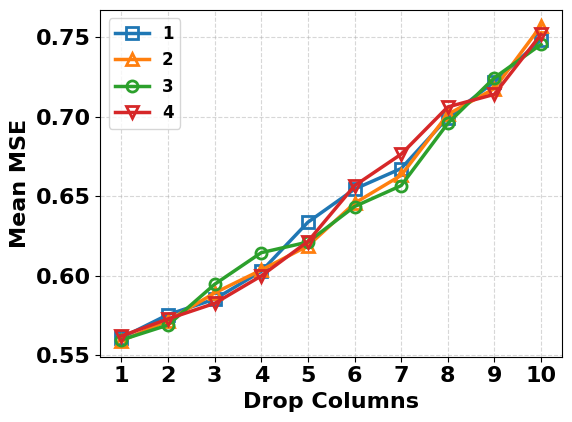

In [3]:
# 同样读取 data，无需重复读取
plt.figure(figsize=(6, 4.5))

for i, idx in enumerate(idx_list):
    mses = [data[idx][drop_num]["mean_mse"] for drop_num in drop_nums]
    plt.plot(
        range(1, 11),
        mses,
        marker=markers[i],
        color=colors[i],
        linewidth=2.5,
        markersize=8,
        markerfacecolor='none',
        markeredgewidth=2,
        label=f'{idx}'
    )

plt.xlabel("Drop Columns", fontweight='bold')
plt.ylabel("Mean MSE", fontweight='bold')
plt.xticks(range(1, 11), fontweight='bold')
plt.yticks(fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(prop={'weight': 'bold', 'size': 12})
plt.tight_layout()
plt.savefig("mean_mse.pdf", bbox_inches='tight')
